# Load dependencies

In [1]:
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Read the document
with open('document.txt', 'r') as document:
    document_lines = document.readlines()

print(document_lines)

['I am happy to join with you today in what will go down in history as the greatest demonstration for freedom in the history of our nation.\n', '\n', 'Five score years ago, a great American, in whose symbolic shadow we stand today, signed the Emancipation Proclamation. This momentous decree came as a great beacon light of hope to millions of Negro slaves who had been seared in the flames of withering injustice. It came as a joyous daybreak to end the long night of their captivity.\n', '\n', 'But one hundred years later, the Negro still is not free. One hundred years later, the life of the Negro is still sadly crippled by the manacles of segregation and the chains of discrimination. One hundred years later, the Negro lives on a lonely island of poverty in the midst of a vast ocean of material prosperity.']


# Preprocess text

In [3]:
# Store all the vocabulary
vocab = set()
stopwords_english = stopwords.words('english')

def preprocess(sentence):
    processes_sen = re.sub('[^a-zA-Z]', ' ', sentence).lower()
    row_tokenized = word_tokenize(processes_sen)
    content = []
    for word in row_tokenized:
        if word not in stopwords_english and word not in string.punctuation:
            stemmed_word = stemmer.stem(word)
            vocab.add(stemmed_word)
            content.append(stemmed_word)
    processed_sen = ' '.join(content)
    return processed_sen

processed_lines = [preprocess(line) for line in document_lines]
print(processed_lines)

['happi join today go histori greatest demonstr freedom histori nation', '', 'five score year ago great american whose symbol shadow stand today sign emancip proclam moment decre came great beacon light hope million negro slave sear flame wither injustic came joyou daybreak end long night captiv', '', 'one hundr year later negro still free one hundr year later life negro still sadli crippl manacl segreg chain discrimin one hundr year later negro live lone island poverti midst vast ocean materi prosper']


In [4]:
word2idx = {word: idx for idx, word in enumerate(vocab, start=1)}
idx2word = {idx: word for idx, word in enumerate(vocab, start=1)}
print(word2idx)
print(idx2word)

{'island': 1, 'moment': 2, 'life': 3, 'segreg': 4, 'one': 5, 'discrimin': 6, 'five': 7, 'decre': 8, 'lone': 9, 'negro': 10, 'stand': 11, 'million': 12, 'poverti': 13, 'slave': 14, 'proclam': 15, 'beacon': 16, 'light': 17, 'live': 18, 'daybreak': 19, 'materi': 20, 'later': 21, 'freedom': 22, 'long': 23, 'nation': 24, 'free': 25, 'night': 26, 'greatest': 27, 'histori': 28, 'emancip': 29, 'hundr': 30, 'shadow': 31, 'ocean': 32, 'injustic': 33, 'score': 34, 'flame': 35, 'demonstr': 36, 'hope': 37, 'captiv': 38, 'whose': 39, 'wither': 40, 'midst': 41, 'sear': 42, 'joyou': 43, 'came': 44, 'still': 45, 'ago': 46, 'american': 47, 'year': 48, 'prosper': 49, 'symbol': 50, 'great': 51, 'go': 52, 'manacl': 53, 'sadli': 54, 'join': 55, 'crippl': 56, 'sign': 57, 'chain': 58, 'vast': 59, 'today': 60, 'end': 61, 'happi': 62}
{1: 'island', 2: 'moment', 3: 'life', 4: 'segreg', 5: 'one', 6: 'discrimin', 7: 'five', 8: 'decre', 9: 'lone', 10: 'negro', 11: 'stand', 12: 'million', 13: 'poverti', 14: 'slave',

# Prepare the Data

In [5]:
# Initialize a list to store target-context pairs
target_context_pairs = []
window_size = 2

for sentence in processed_lines:
    sentence = sentence.split()
    for idx, word in enumerate(sentence):
        context_range = range(max(0, idx - window_size), min(idx + window_size + 1, len(sentence)))
        for context_idx in context_range:
            if context_idx != idx:
                target_context_pairs.append((word, sentence[context_idx]))

# Mapping words to indices
targets = np.array([word2idx[word] for word, _ in target_context_pairs])
contexts = np.array([word2idx[word] for _, word in target_context_pairs])

print(targets[:5])
print(contexts[:5])

[62 62 55 55 55]
[55 60 62 60 52]


In [6]:
# Convert contexts to one-hot encoding
vocab_size = len(vocab) + 1
contexts_one_hot = to_categorical(contexts, num_classes=vocab_size)

# Build the Word2Vec Neural Network Using Skip Gram

In [ ]:
# Define hyperparameters
embedding_dim = 2
epochs = 1000
batch_size = 64
learning_rate = 0.001

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=1, name='embedding'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(vocab_size, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy')

In [ ]:
# Train the model
model.fit(targets, contexts_one_hot, epochs=epochs, batch_size=batch_size, verbose=1)

In [12]:
# Extract the embeddings
embedding_layer = model.get_layer('embedding')
embeddings = embedding_layer.get_weights()[0]
print(embeddings[:5])

[[-0.02862965  0.036332  ]
 [-1.5950222   0.19026308]
 [ 0.45631638  0.81450653]
 [-0.08023407 -0.74152935]
 [-0.29781416 -0.05602155]]


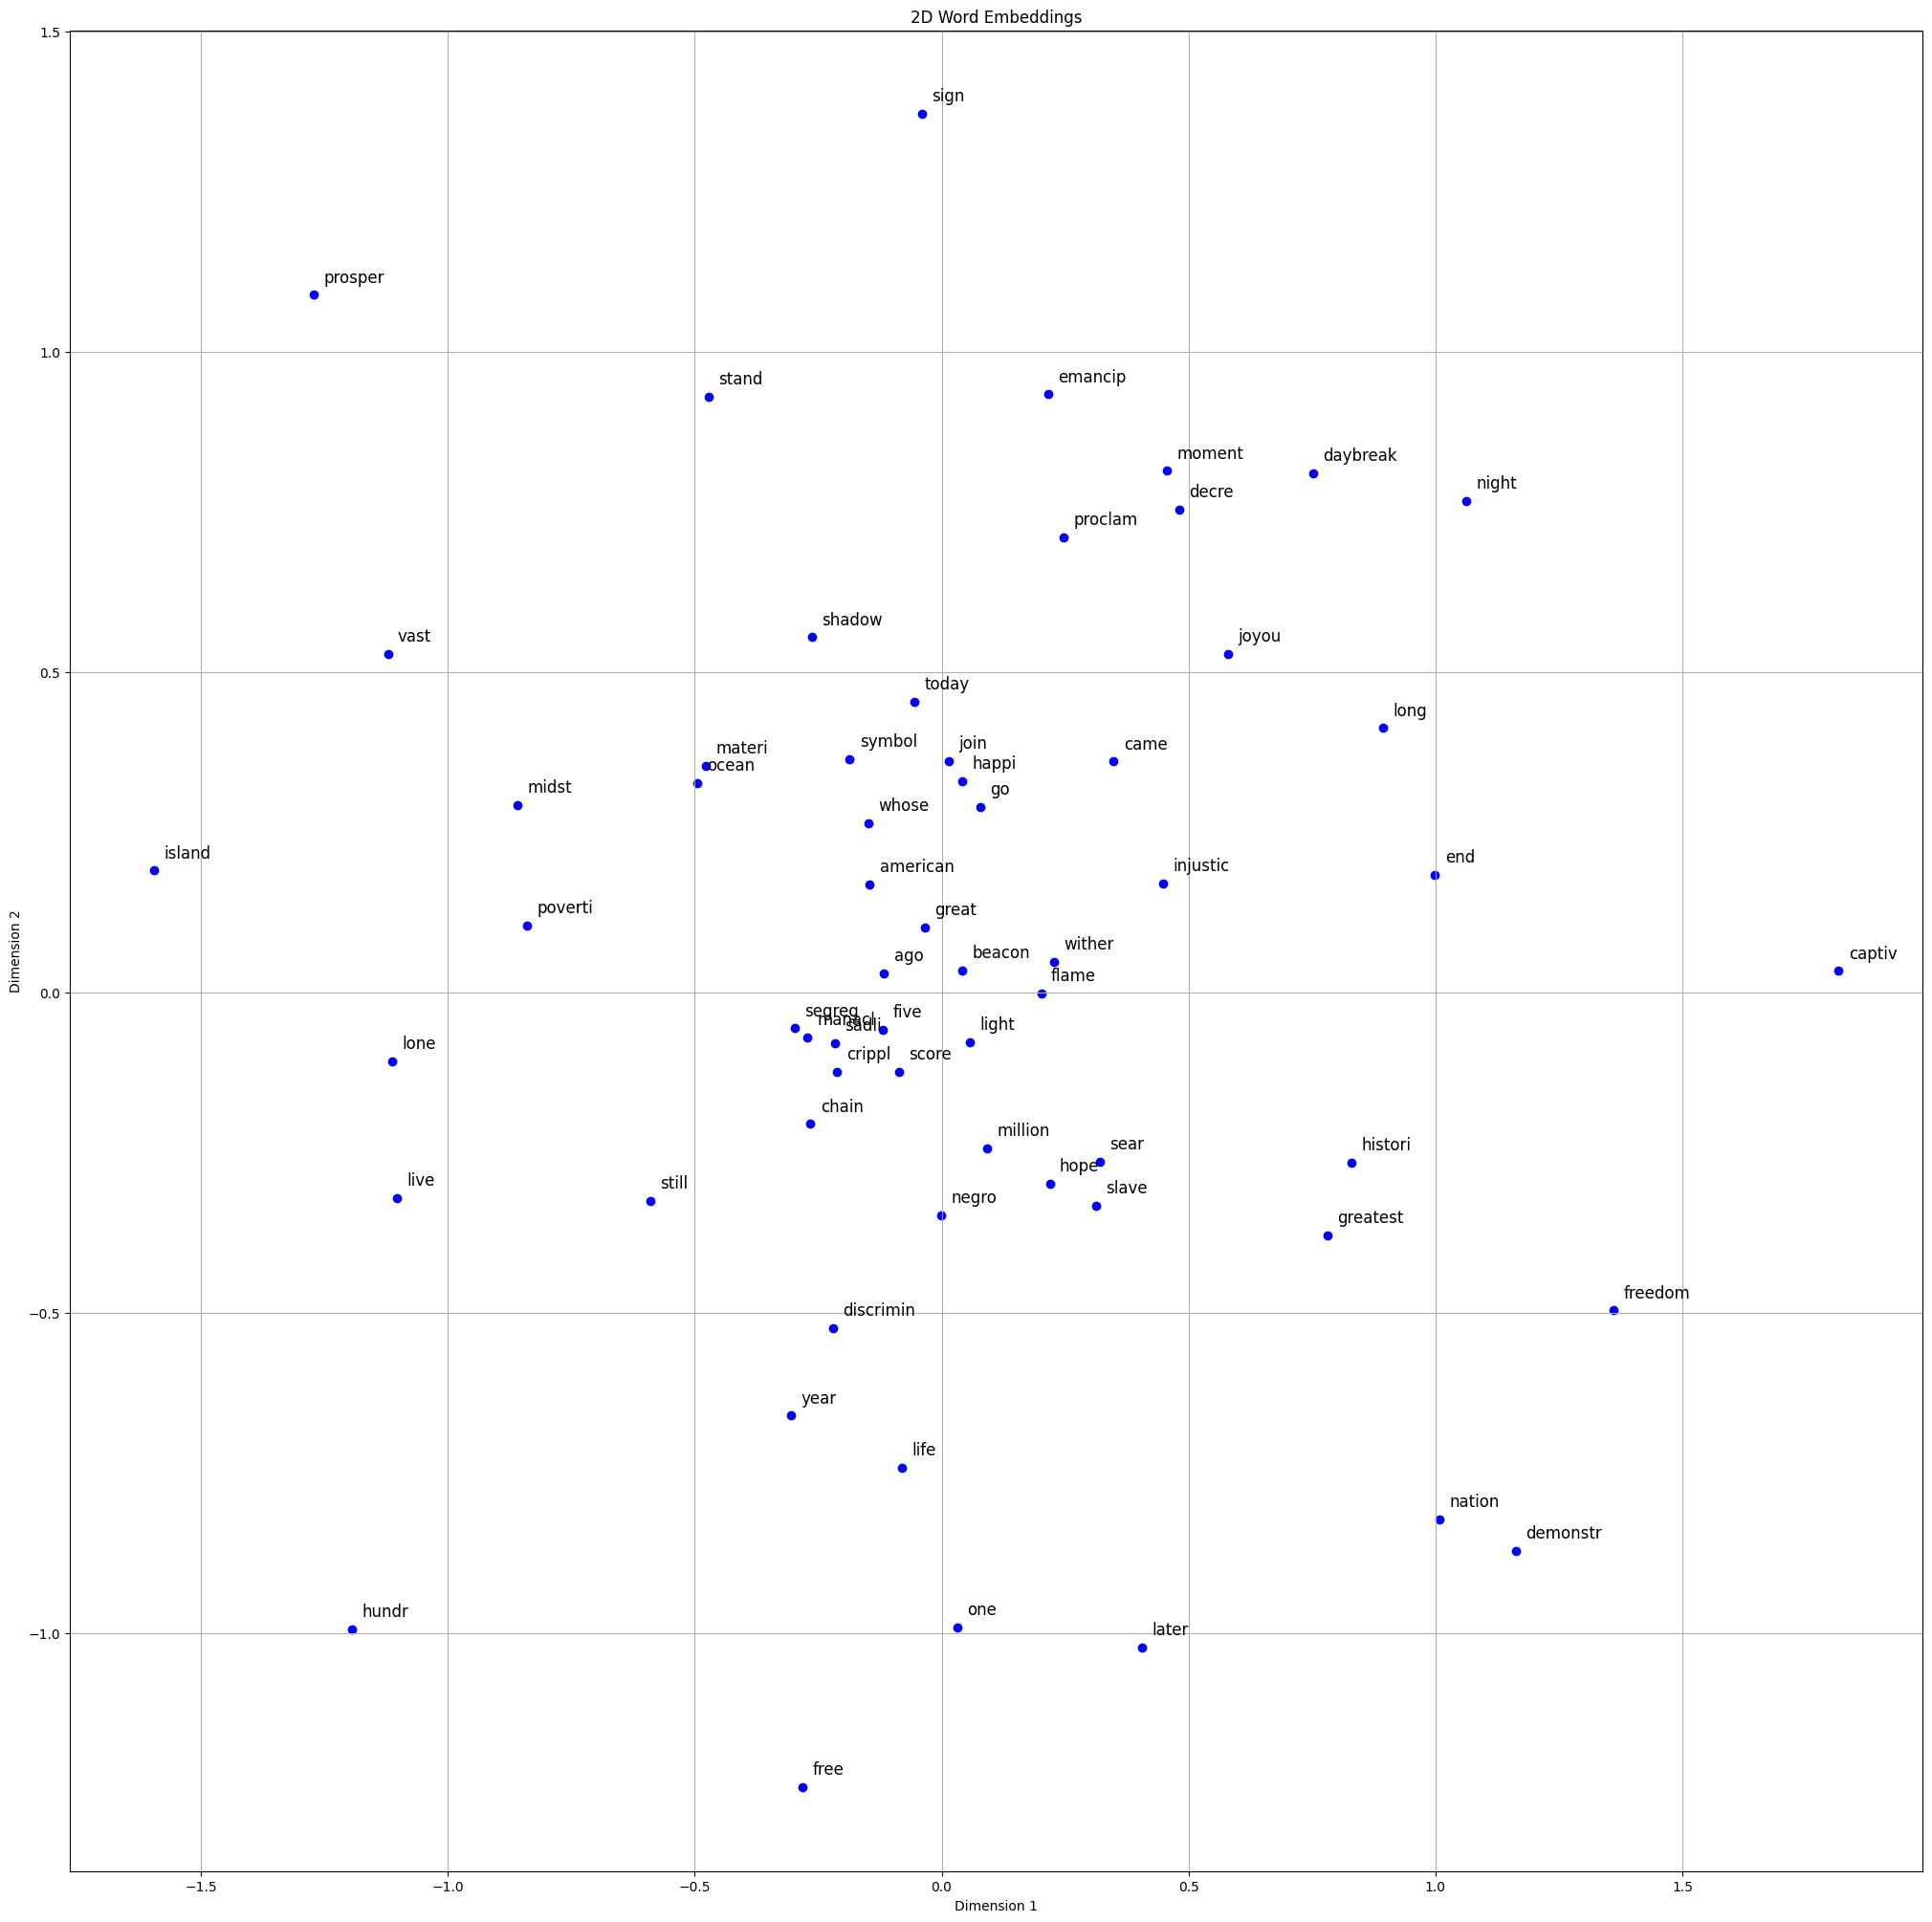

In [16]:
# Plot the embeddings
plt.figure(figsize=(25, 25))

for word, idx in word2idx.items():
    x, y = embeddings[idx]
    plt.scatter(x, y, marker='o', color='blue')
    plt.text(x + 0.02, y + 0.02, word, fontsize=12)

plt.title('2D Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()